In [8]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling1D, Embedding, Add, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# ----- 0. GLOBAL CONSTANTS AND KEYPOINT DEFINITIONS -----
KEYPOINT_NAMES = [
    'Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear',
    'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow',
    'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip',
    'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle'
]
SORTED_KEYPOINT_NAMES = sorted(KEYPOINT_NAMES)
KEYPOINT_DICT = {name: i for i, name in enumerate(SORTED_KEYPOINT_NAMES)}
NUM_KEYPOINTS = len(KEYPOINT_DICT)

print("--- Initializing Keypoint Definitions ---")
print(f"SORTED_KEYPOINT_NAMES (used for ordering): {SORTED_KEYPOINT_NAMES}")
print(f"Generated KEYPOINT_DICT: {KEYPOINT_DICT}")
print(f"NUM_KEYPOINTS: {NUM_KEYPOINTS}")
if NUM_KEYPOINTS != 17:
    print(f"WARNING: NUM_KEYPOINTS is {NUM_KEYPOINTS}, expected 17.")
print("----------------------------------------")

--- Initializing Keypoint Definitions ---
SORTED_KEYPOINT_NAMES (used for ordering): ['Left Ankle', 'Left Ear', 'Left Elbow', 'Left Eye', 'Left Hip', 'Left Knee', 'Left Shoulder', 'Left Wrist', 'Nose', 'Right Ankle', 'Right Ear', 'Right Elbow', 'Right Eye', 'Right Hip', 'Right Knee', 'Right Shoulder', 'Right Wrist']
Generated KEYPOINT_DICT: {'Left Ankle': 0, 'Left Ear': 1, 'Left Elbow': 2, 'Left Eye': 3, 'Left Hip': 4, 'Left Knee': 5, 'Left Shoulder': 6, 'Left Wrist': 7, 'Nose': 8, 'Right Ankle': 9, 'Right Ear': 10, 'Right Elbow': 11, 'Right Eye': 12, 'Right Hip': 13, 'Right Knee': 14, 'Right Shoulder': 15, 'Right Wrist': 16}
NUM_KEYPOINTS: 17
----------------------------------------


In [10]:
# ----- 1. HELPER FUNCTION FOR KEYPOINT INDICES -----
def get_kpt_indices(keypoint_name):
    if keypoint_name not in KEYPOINT_DICT:
        available_keys = list(KEYPOINT_DICT.keys())
        similar_keys = [k for k in available_keys if keypoint_name.lower() in k.lower() or k.lower() in keypoint_name.lower()]
        error_msg = f"Keypoint name '{keypoint_name}' not found in KEYPOINT_DICT. "
        error_msg += f"Available keys: {available_keys}. "
        if similar_keys: error_msg += f"Did you mean: {similar_keys}? "
        raise ValueError(error_msg)
    kp_idx = KEYPOINT_DICT[keypoint_name]
    return kp_idx * 3, kp_idx * 3 + 1, kp_idx * 3 + 2

In [11]:
# ----- 2. SKELETON NORMALIZATION FUNCTION -----
def normalize_skeleton(sequence_data, min_confidence=0.3):
    normalized_sequence = np.copy(sequence_data)
    ref_kp_names = {
        'ls': 'Left Shoulder', 'rs': 'Right Shoulder',
        'lh': 'Left Hip', 'rh': 'Right Hip'
    }
    for ref_kp_key, ref_kp_name_val in ref_kp_names.items():
        if ref_kp_name_val not in KEYPOINT_DICT:
            print(f"WARNING in normalize_skeleton: Ref keypoint '{ref_kp_name_val}' not in KEYPOINT_DICT.")

    for t in range(sequence_data.shape[0]):
        frame_data = sequence_data[t, :]
        current_frame_normalized = np.copy(frame_data)
        try:
            ls_x_idx, ls_y_idx, ls_c_idx = get_kpt_indices(ref_kp_names['ls'])
            rs_x_idx, rs_y_idx, rs_c_idx = get_kpt_indices(ref_kp_names['rs'])
            lh_x_idx, lh_y_idx, lh_c_idx = get_kpt_indices(ref_kp_names['lh'])
            rh_x_idx, rh_y_idx, rh_c_idx = get_kpt_indices(ref_kp_names['rh'])
        except ValueError:
            normalized_sequence[t, :] = frame_data; continue

        ls_x, ls_y, ls_c = frame_data[ls_x_idx], frame_data[ls_y_idx], frame_data[ls_c_idx]
        rs_x, rs_y, rs_c = frame_data[rs_x_idx], frame_data[rs_y_idx], frame_data[rs_c_idx]
        lh_x, lh_y, lh_c = frame_data[lh_x_idx], frame_data[lh_y_idx], frame_data[lh_c_idx]
        rh_x, rh_y, rh_c = frame_data[rh_x_idx], frame_data[rh_y_idx], frame_data[rh_c_idx]

        mid_shoulder_x, mid_shoulder_y = np.nan, np.nan
        valid_ls, valid_rs = ls_c > min_confidence, rs_c > min_confidence
        if valid_ls and valid_rs: mid_shoulder_x, mid_shoulder_y = (ls_x + rs_x) / 2, (ls_y + rs_y) / 2
        elif valid_ls: mid_shoulder_x, mid_shoulder_y = ls_x, ls_y
        elif valid_rs: mid_shoulder_x, mid_shoulder_y = rs_x, rs_y

        mid_hip_x, mid_hip_y = np.nan, np.nan
        valid_lh, valid_rh = lh_c > min_confidence, rh_c > min_confidence
        if valid_lh and valid_rh: mid_hip_x, mid_hip_y = (lh_x + rh_x) / 2, (lh_y + rh_y) / 2
        elif valid_lh: mid_hip_x, mid_hip_y = lh_x, lh_y
        elif valid_rh: mid_hip_x, mid_hip_y = rh_x, rh_y

        if np.isnan(mid_hip_x) or np.isnan(mid_hip_y):
            normalized_sequence[t, :] = frame_data; continue

        reference_height = np.nan
        if not np.isnan(mid_shoulder_y) and not np.isnan(mid_hip_y):
            reference_height = np.abs(mid_shoulder_y - mid_hip_y)

        perform_scaling = not (np.isnan(reference_height) or reference_height < 1e-5)

        for kp_i in range(NUM_KEYPOINTS):
            x_i_col, y_i_col = kp_i * 3, kp_i * 3 + 1
            current_frame_normalized[x_i_col] -= mid_hip_x
            current_frame_normalized[y_i_col] -= mid_hip_y
            if perform_scaling:
                current_frame_normalized[x_i_col] /= reference_height
                current_frame_normalized[y_i_col] /= reference_height
        normalized_sequence[t, :] = current_frame_normalized
    return normalized_sequence

In [12]:
# ----- 3. DATA LOADING FUNCTION  -----
def load_dataset(data_path, expected_shape_template=(30, None), normalize=True, min_confidence_norm=0.3):
    if NUM_KEYPOINTS is None or NUM_KEYPOINTS == 0:
        raise ValueError("NUM_KEYPOINTS is not set or is zero.")
    expected_shape = (expected_shape_template[0], NUM_KEYPOINTS * 3)
    
    X, y = [], []
    npy_filepaths = []

    print(f"Loading data from: {data_path}, expecting shape {expected_shape} for .npy files.")
    for label_name, label_val in [('no_fall', 0), ('fall', 1)]:
        folder = os.path.join(data_path, label_name)
        if not os.path.isdir(folder):
            print(f"Warning: Subfolder not found for label '{label_name}': {folder}")
            continue
        
        files_in_folder = glob(os.path.join(folder, "*.npy"))
        print(f"Found {len(files_in_folder)} .npy files in {folder}")
        
        loaded_count_for_label = 0
        for file_path_str in files_in_folder:
            try:
                arr = np.load(file_path_str)
            except Exception as e:
                print(f"Warning: Could not load file {file_path_str}: {e}")
                continue

            if arr.shape == expected_shape:
                if normalize:
                    arr_normalized = normalize_skeleton(arr, min_confidence=min_confidence_norm)
                    if np.isnan(arr_normalized).any():
                        arr_normalized = np.nan_to_num(arr_normalized, nan=0.0, posinf=0.0, neginf=0.0)
                    X.append(arr_normalized)
                else:
                    X.append(arr)
                y.append(label_val)
                npy_filepaths.append(file_path_str)
                loaded_count_for_label += 1
            else:
                print(f"Warning: Skipping file {file_path_str} due to incorrect shape: {arr.shape}. Expected: {expected_shape}")
        print(f"Successfully loaded {loaded_count_for_label} samples for label '{label_name}'.")

    if not X:
        print(f"Critical Warning: No data was loaded from {data_path}.")
        return np.array([]), np.array([]), []
        
    return np.array(X), np.array(y), npy_filepaths

In [13]:
# --- Transformer Encoder Block ---
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout_rate=0.1, name_prefix=""):
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model // num_heads, dropout=dropout_rate,
        name=f"{name_prefix}_mha"
    )(inputs, inputs, inputs)
    attention_output = Dropout(dropout_rate, name=f"{name_prefix}_mha_dropout")(attention_output)
    out1 = LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_layernorm1")(inputs + attention_output)

    ffn_output = Dense(ff_dim, activation="relu", name=f"{name_prefix}_ffn_dense1")(out1)
    ffn_output = Dense(d_model, name=f"{name_prefix}_ffn_dense2")(ffn_output)
    ffn_output = Dropout(dropout_rate, name=f"{name_prefix}_ffn_dropout")(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_layernorm2")(out1 + ffn_output)
    return out2

# --- Positional Embedding Layer (Learned) ---
def get_positional_embedding(seq_len, d_model, name_prefix=""):
    positions = tf.range(start=0, limit=seq_len, delta=1)
    position_embeddings_2d = Embedding(input_dim=seq_len, output_dim=d_model, name=f"{name_prefix}_pos_embed")(positions)
    position_embeddings_3d = tf.expand_dims(position_embeddings_2d, axis=0)
    return position_embeddings_3d



In [14]:
# --- Model Creation Function ---
def create_transformer_classifier(
    input_shape,
    num_encoder_blocks=2,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    projection_dim=None,
    final_dense_units=32,
    dropout_rate=0.1,
    learning_rate=0.0005
):
    timesteps, num_features = input_shape
    if projection_dim is None: projection_dim = d_model

    inputs = Input(shape=input_shape, name="input_features")
    projected_x = Dense(projection_dim, name="feature_projection")(inputs)
    positional_embeddings = get_positional_embedding(timesteps, projection_dim, name_prefix="pos_enc")
    x = Add(name="add_positional_encoding")([projected_x, positional_embeddings])
    x = Dropout(dropout_rate, name="input_dropout_after_pos_enc")(x)

    for i in range(num_encoder_blocks):
        x = transformer_encoder_block(x, projection_dim, num_heads, ff_dim, dropout_rate, name_prefix=f"encoder_block_{i+1}")

    x = GlobalAveragePooling1D(name="global_avg_pooling")(x)
    x = Dropout(dropout_rate, name="dropout_after_pooling")(x)
    x = Dense(final_dense_units, activation="relu", name="final_dense_1")(x)
    x = Dropout(dropout_rate / 2, name="dropout_final_dense")(x)
    outputs = Dense(1, activation="sigmoid", name="output_sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # ใช้ tf.keras.metrics.F1Score
    # สำหรับ binary classification ที่มี output เป็น sigmoid และ target เป็น 0 หรือ 1,
    # Keras F1Score จะคำนวณ F1 ของ positive class (1) โดย default
    # ถ้าต้องการ Macro F1 (เฉลี่ย F1 ของ class 0 และ class 1)
    f1_macro_metric = tf.keras.metrics.F1Score(
        average='macro', # คำนวณ F1 สำหรับแต่ละคลาสแล้วเฉลี่ย
        threshold=0.5,   # Threshold สำหรับการแปลง probability เป็น class label
        name='f1_macro'  # ชื่อนี้จะปรากฏใน history.history
    )
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_macro_metric]) # เพิ่ม f1_macro_metric
    return model


In [15]:
#--- Load Dataset ---

# Paths 
base_train = '/kaggle/input/fall-dataset30/train'
base_val   = '/kaggle/input/fall-dataset30/val'
base_test  = '/kaggle/input/fall-dataset30/test'

# ----- Parameters -----
TIMESTEPS = 30
EXPECTED_SHAPE_TEMPLATE = (TIMESTEPS, None)
MIN_CONF_NORM = 0.2

print("\n--- Loading Training Data ---")
X_train_orig, y_train_orig, train_npy_filepaths = load_dataset(
    base_train, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, normalize=True, min_confidence_norm=MIN_CONF_NORM
)
print("\n--- Loading Validation Data ---")
X_val_orig, y_val_orig, val_npy_filepaths = load_dataset(
    base_val, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, normalize=True, min_confidence_norm=MIN_CONF_NORM
)
print("\n--- Loading Test Data ---")
X_test_orig, y_test_orig, test_npy_filepaths = load_dataset(
    base_test, expected_shape_template=EXPECTED_SHAPE_TEMPLATE, normalize=True, min_confidence_norm=MIN_CONF_NORM
)

if X_train_orig.size == 0:
    print("FATAL ERROR: Training data is empty.")
else:
    if len(X_train_orig) == len(train_npy_filepaths): print(f"Training set: Loaded {len(X_train_orig)} samples and filepaths.")
    else: print(f"WARNING: Mismatch in Training set! Samples: {len(X_train_orig)}, Filepaths: {len(train_npy_filepaths)}.")

if X_val_orig.size > 0:
    if len(X_val_orig) == len(val_npy_filepaths): print(f"Validation set: Loaded {len(X_val_orig)} samples and filepaths.")
    else: print(f"WARNING: Mismatch in Validation set! Samples: {len(X_val_orig)}, Filepaths: {len(val_npy_filepaths)}.")
else: print("Validation data is empty or was not loaded.")

if X_test_orig.size > 0:
    if len(X_test_orig) == len(test_npy_filepaths): print(f"Test set: Loaded {len(X_test_orig)} samples and filepaths.")
    else: print(f"WARNING: Mismatch in Test set! Samples: {len(X_test_orig)}, Filepaths: {len(test_npy_filepaths)}.")
else: print("Test data is empty or was not loaded.")
    
print(f"\nShapes after loading:")
print(f"Train: X={X_train_orig.shape if X_train_orig.size > 0 else 'Empty'}, y={y_train_orig.shape if y_train_orig.size > 0 else 'Empty'}")
print(f"Val:   X={X_val_orig.shape if X_val_orig.size > 0 else 'Empty'}, y={y_val_orig.shape if y_val_orig.size > 0 else 'Empty'}")
print(f"Test:  X={X_test_orig.shape if X_test_orig.size > 0 else 'Empty'}, y={y_test_orig.shape if y_test_orig.size > 0 else 'Empty'}")

if 'NUM_KEYPOINTS' in locals() and isinstance(NUM_KEYPOINTS, int) and NUM_KEYPOINTS > 0:
    transformer_input_shape = (TIMESTEPS, NUM_KEYPOINTS * 3)
    print(f"\nTransformer Input Shape: {transformer_input_shape}")
else:
    print("\nERROR: NUM_KEYPOINTS not defined correctly. Cannot determine Transformer Input Shape.")
    transformer_input_shape = (TIMESTEPS, -1)


--- Loading Training Data ---
Loading data from: /kaggle/input/fall-dataset30/train, expecting shape (30, 51) for .npy files.
Found 3804 .npy files in /kaggle/input/fall-dataset30/train/no_fall
Successfully loaded 3804 samples for label 'no_fall'.
Found 3851 .npy files in /kaggle/input/fall-dataset30/train/fall
Successfully loaded 3851 samples for label 'fall'.

--- Loading Validation Data ---
Loading data from: /kaggle/input/fall-dataset30/val, expecting shape (30, 51) for .npy files.
Found 816 .npy files in /kaggle/input/fall-dataset30/val/no_fall
Successfully loaded 816 samples for label 'no_fall'.
Found 825 .npy files in /kaggle/input/fall-dataset30/val/fall
Successfully loaded 825 samples for label 'fall'.

--- Loading Test Data ---
Loading data from: /kaggle/input/fall-dataset30/test, expecting shape (30, 51) for .npy files.
Found 815 .npy files in /kaggle/input/fall-dataset30/test/no_fall
Successfully loaded 815 samples for label 'no_fall'.
Found 826 .npy files in /kaggle/input


--- Starting 5-Fold Cross-Validation with Transformer Classifier ---
--- Fold 1/5 ---


I0000 00:00:1749206636.214640      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749206636.215369      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1749206651.412800     103 service.cc:148] XLA service 0x7f96d802d800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749206651.413309     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749206651.413330     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749206652.664443     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


 24/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4841 - f1_macro: 0.4918 - loss: 0.7365

I0000 00:00:1749206660.942292     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.7002 - f1_macro: 0.6819 - loss: 0.5393 - val_accuracy: 0.8478 - val_f1_macro: 0.8429 - val_loss: 0.3350
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8611 - f1_macro: 0.8605 - loss: 0.3420 - val_accuracy: 0.8896 - val_f1_macro: 0.8853 - val_loss: 0.2953
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8864 - f1_macro: 0.8841 - loss: 0.2832 - val_accuracy: 0.9157 - val_f1_macro: 0.9164 - val_loss: 0.2292
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9136 - f1_macro: 0.9122 - loss: 0.2301 - val_accuracy: 0.9308 - val_f1_macro: 0.9313 - val_loss: 0.2027
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9279 - f1_macro: 0.9277 - loss: 0.2083 - val_accuracy: 0.9321 - val_f1_macro: 0.9321 - val_loss: 0.1840
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9302 - f1_macro: 0.9288 - loss: 0.1889 - val_accuracy: 0.9314 - val_f1_macro: 0.9307 - val_lo

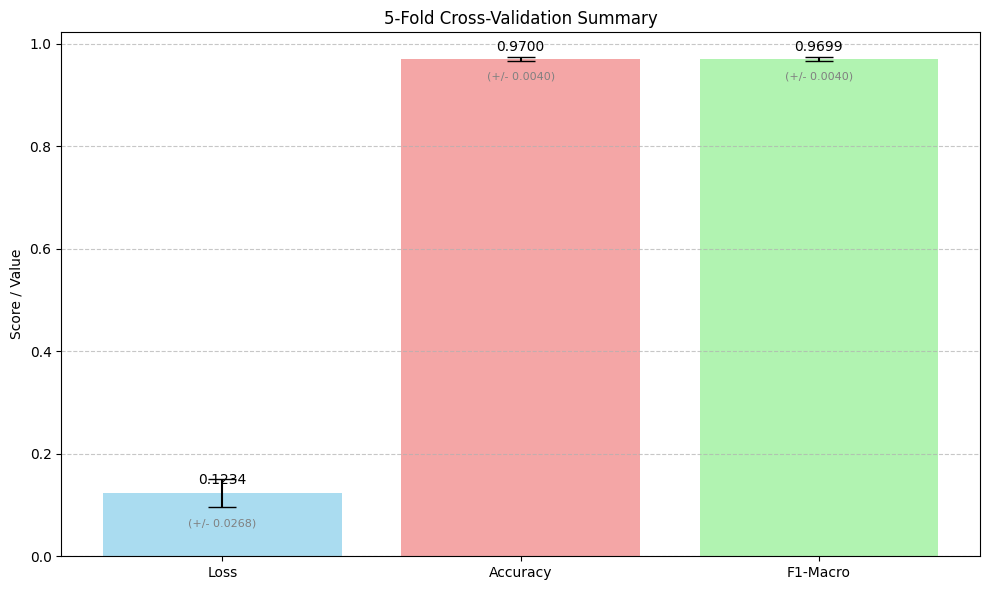

In [16]:
# ----- Model Parameters -----
NUM_ENCODER_BLOCKS = 3
D_MODEL = 64
NUM_HEADS = 4
FF_DIM = D_MODEL * 2
PROJECTION_DIM = D_MODEL
FINAL_DENSE_UNITS = 16
DROPOUT_RATE = 0.06
LEARNING_RATE = 0.0001

# ----- Cross-Validation -----
N_SPLITS_CV = 5
EPOCHS_CV = 50
BATCH_SIZE_CV = 32
cv_accuracies, cv_losses, cv_f1_macros = [], [], []
fold_no = 1

print(f"\n--- Starting {N_SPLITS_CV}-Fold Cross-Validation with Transformer Classifier ---")
if X_train_orig.shape[0] > 0 and y_train_orig.shape[0] >= N_SPLITS_CV:
    skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X_train_orig, y_train_orig):
        print(f"--- Fold {fold_no}/{N_SPLITS_CV} ---")
        X_cv_train, X_cv_val = X_train_orig[train_idx], X_train_orig[val_idx]
        y_cv_train_1d, y_cv_val_1d = y_train_orig[train_idx], y_train_orig[val_idx] # Keep 1D versions if needed elsewhere

        # --- RESHAPE y_true for Keras F1Score metric ---
        y_cv_train_2d = y_cv_train_1d.reshape(-1, 1)
        y_cv_val_2d = y_cv_val_1d.reshape(-1, 1)
        
        cv_model = create_transformer_classifier(
            input_shape=transformer_input_shape, num_encoder_blocks=NUM_ENCODER_BLOCKS,
            d_model=D_MODEL, num_heads=NUM_HEADS, ff_dim=FF_DIM,
            projection_dim=PROJECTION_DIM, final_dense_units=FINAL_DENSE_UNITS,
            dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE
        )
        
        early_stopping_cv = EarlyStopping(monitor='val_f1_macro', patience=15, verbose=1, mode='max', restore_best_weights=True)
        
        history_cv = cv_model.fit(X_cv_train, y_cv_train_2d, # Use 2D y_true for training
                                  epochs=EPOCHS_CV, batch_size=BATCH_SIZE_CV, 
                                  validation_data=(X_cv_val, y_cv_val_2d), # Use 2D y_true for validation
                                  callbacks=[early_stopping_cv],
                                  verbose=1) 
        
        # Evaluate with 2D y_true
        eval_results_cv = cv_model.evaluate(X_cv_val, y_cv_val_2d, verbose=0)
        loss, accuracy, f1_macro = eval_results_cv[0], eval_results_cv[1], eval_results_cv[2]

        print(f"Fold {fold_no} - CV Val Loss: {loss:.4f}, CV Val Acc: {accuracy:.4f}, CV Val F1-Macro: {f1_macro:.4f}")
        cv_losses.append(loss); cv_accuracies.append(accuracy); cv_f1_macros.append(f1_macro)
        fold_no += 1

    if cv_accuracies: # ตรวจสอบว่ามีผลลัพธ์จาก CV หรือไม่
        print("\n--- Cross-Validation Summary ---")
        mean_loss = np.mean(cv_losses)
        std_loss = np.std(cv_losses)
        mean_accuracy = np.mean(cv_accuracies)
        std_accuracy = np.std(cv_accuracies)
        
        print(f"Average CV Loss: {mean_loss:.4f} (+/- {std_loss:.4f})")
        print(f"Average CV Accuracy: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")
        
        if cv_f1_macros: # ตรวจสอบว่ามีการเก็บค่า F1-Macro หรือไม่
             mean_f1_macro = np.mean(cv_f1_macros)
             std_f1_macro = np.std(cv_f1_macros)
             print(f"Average CV F1-Macro: {mean_f1_macro:.4f} (+/- {std_f1_macro:.4f})")

        # ----- Plotting Cross-Validation Results -----
        metrics_names = ['Loss', 'Accuracy']
        mean_values = [mean_loss, mean_accuracy]
        std_dev_values = [std_loss, std_accuracy]

        if cv_f1_macros:
            metrics_names.append('F1-Macro')
            mean_values.append(mean_f1_macro)
            std_dev_values.append(std_f1_macro)

        x_pos = np.arange(len(metrics_names))

        fig, ax = plt.subplots(figsize=(10, 6)) # ปรับขนาดกราฟตามความเหมาะสม
        
        # สร้าง Bar chart พร้อม Error bars (แสดงส่วนเบี่ยงเบนมาตรฐาน)
        bars = ax.bar(x_pos, mean_values, yerr=std_dev_values, align='center', alpha=0.7, ecolor='black', capsize=10, color=['skyblue', 'lightcoral', 'lightgreen'][:len(metrics_names)])
        ax.set_ylabel('Score / Value')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(metrics_names)
        ax.set_title(f'{N_SPLITS_CV}-Fold Cross-Validation Summary')
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

        # เพิ่มตัวเลขค่าเฉลี่ยบนแท่งกราฟ
        for i, bar in enumerate(bars):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + (std_dev_values[i] * 0.1) + 0.01, f"{yval:.4f}", va='bottom', ha='center', fontsize=10)
             # แสดงค่าส่วนเบี่ยงเบนมาตรฐานใต้ค่าเฉลี่ย (ถ้าต้องการ)
            plt.text(bar.get_x() + bar.get_width()/2.0, yval - (std_dev_values[i] * 1.1) - 0.02, f"(+/- {std_dev_values[i]:.4f})", va='top', ha='center', fontsize=8, color='gray')


        plt.tight_layout()
        plt.show()

    else: 
        print("Cross-validation did not produce results (or was skipped), so no summary plot will be generated.")
else:
    print(f"Skipping CV: Training data empty or too few samples for {N_SPLITS_CV} splits.")

In [17]:
# ----- Train Final Model -----
#EPOCHS_FINAL = 40 
BATCH_SIZE_FINAL = 32
EPOCHS_FINAL_NEW = 60  # เพิ่มจำนวน Epochs สำหรับการฝึกที่นานขึ้น
PATIENCE_FINAL_NEW = 10 # เพิ่ม Patience สำหรับ EarlyStopping
history_final = None 

# --- LEARNING RATE PARAMETERS FOR FINAL MODEL SCHEDULER ---
INITIAL_LR_FINAL = 0.0001  # <<<<----- ปรับค่าเริ่มต้นที่นี่ (เช่น 0.0005 หรือ 0.00025)
END_LR_FINAL = 0.00005     # <<<<----- ปรับค่าสุดท้ายที่นี่ (เช่น 0.00001 หรือ 0.000005)

if X_train_orig.shape[0] > 0:
    y_train_orig_2d = y_train_orig.reshape(-1, 1)
    y_val_orig_2d = None
    if X_val_orig.size > 0 and y_val_orig.size > 0:
        y_val_orig_2d = y_val_orig.reshape(-1, 1)

    print("\n--- Training Final Model with Transformer Classifier ---")
    
    # สร้าง final_model ด้วย create_transformer_classifier
    # learning_rate ที่ส่งเข้าไปใน create_transformer_classifier จะไม่ถูกใช้
    # ถ้าเรา recompile ด้วย optimizer ใหม่ด้านล่าง
    final_model = create_transformer_classifier(
        input_shape=transformer_input_shape, num_encoder_blocks=NUM_ENCODER_BLOCKS,
        d_model=D_MODEL, num_heads=NUM_HEADS, ff_dim=FF_DIM,
        projection_dim=PROJECTION_DIM, final_dense_units=FINAL_DENSE_UNITS,
        dropout_rate=DROPOUT_RATE, # ใช้ DROPOUT_RATE ที่ตั้งไว้
        learning_rate=0.0005 # ค่า dummy หรือ initial LR เดิม, เพราะจะ recompile อยู่ดี
    )

    # --- DEFINE LEARNING RATE SCHEDULE FOR FINAL MODEL ---
    num_train_samples_final = X_train_orig.shape[0]
    total_decay_steps_final = (num_train_samples_final // BATCH_SIZE_FINAL) * EPOCHS_FINAL_NEW 
    
    final_lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=INITIAL_LR_FINAL, # <<<<----- ใช้ค่าใหม่ที่ตั้งไว้
        decay_steps=total_decay_steps_final,
        end_learning_rate=END_LR_FINAL,         # <<<<----- ใช้ค่าใหม่ที่ตั้งไว้
        power=0.5 # Linear decay (หรือลองค่าอื่น เช่น 0.5)
    )
    
    # สร้าง Optimizer ใหม่ด้วย Learning Rate Schedule
    optimizer_with_schedule_final = Adam(learning_rate=final_lr_schedule)

    # Recompile final_model ด้วย Optimizer ใหม่ที่มี Schedule
    f1_metric_for_recompile = tf.keras.metrics.F1Score(average='macro', threshold=0.5, name='f1_macro')
    final_model.compile(optimizer=optimizer_with_schedule_final,
                        loss='binary_crossentropy',
                        metrics=['accuracy', f1_metric_for_recompile])
    print(f"Recompiled final_model with PolynomialDecay LR schedule (Initial: {INITIAL_LR_FINAL}, End: {END_LR_FINAL}).")

    callbacks_final = []
    validation_data_for_fit = None
    if y_val_orig_2d is not None:
        validation_data_for_fit = (X_val_orig, y_val_orig_2d)
        early_stopping_final = EarlyStopping(
            monitor='val_f1_macro', 
            patience=PATIENCE_FINAL_NEW, # ใช้ PATIENCE_FINAL_NEW ที่ตั้งไว้
            verbose=1, 
            mode='max', 
            restore_best_weights=True
        )
        callbacks_final.append(early_stopping_final)
        
        class PrintLR(tf.keras.callbacks.Callback): # Optional: Callback to print LR
            def on_epoch_end(self, epoch, logs=None):
                current_lr_value = self.model.optimizer.learning_rate
                if isinstance(current_lr_value, tf.keras.optimizers.schedules.LearningRateSchedule):
                    current_lr_value = current_lr_value(self.model.optimizer.iterations)
                try:
                    current_lr_value = tf.keras.backend.get_value(current_lr_value)
                except: pass
                print(f" - LR: {current_lr_value:.7f}", end="")
        callbacks_final.append(PrintLR())

        print(f"Training final model with validation data, LR schedule, and EarlyStopping (patience={PATIENCE_FINAL_NEW}).")
    else:
        print("Training final model without validation data. EarlyStopping on val_f1_macro disabled.")
    
    history_final = final_model.fit(X_train_orig, y_train_orig_2d, 
                                    epochs=EPOCHS_FINAL_NEW, # ใช้ EPOCHS_FINAL_NEW
                                    batch_size=BATCH_SIZE_FINAL, 
                                    validation_data=validation_data_for_fit, 
                                    callbacks=callbacks_final if callbacks_final else None, 
                                    verbose=1)
    
    if final_model:
        if X_test_orig.shape[0] > 0 and y_test_orig.shape[0] > 0:
            y_test_orig_2d = y_test_orig.reshape(-1, 1)
            print("\n--- Evaluating on Test Set (after final training) ---")
            eval_results_final = final_model.evaluate(X_test_orig, y_test_orig_2d, verbose=0)
            test_loss, test_accuracy, test_f1_macro = eval_results_final[0], eval_results_final[1], eval_results_final[2]
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1-Macro: {test_f1_macro:.4f}")
        else:
            print("Skipping evaluation on Test Set: Test data is empty or not provided.")
else:
    print("Final model was not trained (likely due to empty training data).")


# ----- Export Model and Convert to TFLite -----
if 'final_model' in locals() and isinstance(final_model, tf.keras.Model):
    print("\n--- Evaluating on Test Set (Before Export) ---")
    if 'X_test_orig' in locals() and 'y_test_orig' in locals() and X_test_orig.size > 0:
        # --- RESHAPE y_test_orig for Keras F1Score metric during evaluation ---
        y_test_orig_2d_export = y_test_orig.reshape(-1, 1) # Use a different variable name or ensure it's reshaped if not already
        eval_results_export = final_model.evaluate(X_test_orig, y_test_orig_2d_export, verbose=0) # Use 2D y_true
        test_loss_exp, test_acc_exp, test_f1_exp = eval_results_export[0], eval_results_export[1], eval_results_export[2]
        print(f"Test Loss: {test_loss_exp:.4f}, Test Acc: {test_acc_exp:.4f}, Test F1-Macro: {test_f1_exp:.4f}")
    else:
        print("Test data not found or empty for pre-export evaluation.")

    export_directory = 'fall_model_exported_sm'
    try:
        final_model.export(export_directory)
        print(f"Model exported successfully in SavedModel format at: ./{export_directory}")

        print("\nConverting exported SavedModel to TensorFlow Lite...")
        try:
            converter = tf.lite.TFLiteConverter.from_saved_model(export_directory)
            tflite_model_content = converter.convert()
            tflite_model_path = 'fall_detection_transformer.tflite'
            with open(tflite_model_path, 'wb') as f: f.write(tflite_model_content)
            print(f"Model converted to TFLite and saved as {tflite_model_path} ({len(tflite_model_content)/1024:.2f} KB)")
        except Exception as tflite_e:
            print(f"Error during TFLite conversion: {tflite_e}")
    except Exception as e:
        print(f"Error during model export: {e}")
else:
    print("ERROR: 'final_model' not defined or not a Keras Model. Skipping export and TFLite conversion.")


--- Training Final Model with Transformer Classifier ---
Recompiled final_model with PolynomialDecay LR schedule (Initial: 0.0001, End: 5e-05).
Training final model with validation data, LR schedule, and EarlyStopping (patience=10).
Epoch 1/60
240/240 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.7117 - f1_macro: 0.7208 - loss: 0.6093 - val_accuracy: 0.8422 - val_f1_macro: 0.8297 - val_loss: 0.3665
Epoch 2/60
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8402 - f1_macro: 0.8314 - loss: 0.3604 - val_accuracy: 0.8903 - val_f1_macro: 0.8859 - val_loss: 0.2621
Epoch 3/60
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8832 - f1_macro: 0.8775 - loss: 0.2807 - val_accuracy: 0.9177 - val_f1_macro: 0.9170 - val_loss: 0.2115
Epoch 4/60
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9119 - f1_macro: 0.9097 - loss: 0.2275 - val_accuracy: 0.9190 - val_f1_macro: 0.9164 - val_loss: 0.1982
Epoch 5/60
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9275 - f1_macro: 0

W0000 00:00:1749207934.898903      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749207934.898938      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1749207934.927255      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


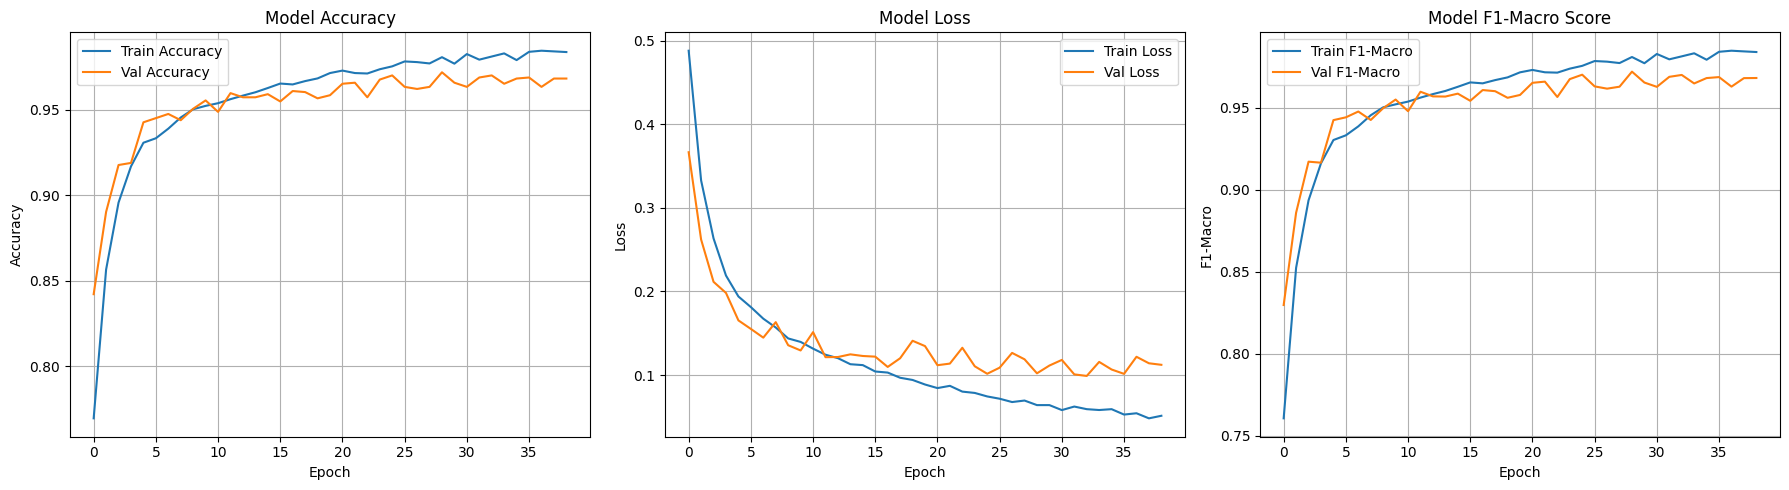

In [18]:
# ----- Plot Training History of Final Model -----
if history_final and hasattr(history_final, 'history') and history_final.history:
    plt.figure(figsize=(18, 5)) # Adjusted for 3 subplots
    
    plt.subplot(1, 3, 1)
    if 'accuracy' in history_final.history: plt.plot(history_final.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history_final.history: plt.plot(history_final.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    
    plt.subplot(1, 3, 2)
    if 'loss' in history_final.history: plt.plot(history_final.history['loss'], label='Train Loss')
    if 'val_loss' in history_final.history: plt.plot(history_final.history['val_loss'], label='Val Loss')
    plt.title('Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 3) # New subplot for F1-Macro
    if 'f1_macro' in history_final.history: plt.plot(history_final.history['f1_macro'], label='Train F1-Macro')
    if 'val_f1_macro' in history_final.history: plt.plot(history_final.history['val_f1_macro'], label='Val F1-Macro')
    plt.title('Model F1-Macro Score'); plt.xlabel('Epoch'); plt.ylabel('F1-Macro'); plt.legend(); plt.grid(True)
    
    plt.tight_layout(); plt.show()
else:
    print("Skipping plotting: final model training history unavailable.")




--- Custom Validation Metrics Report (Threshold: 0.5) ---
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
           Precision     Recall   F1-score   F2-score    Support
no_fall       0.9627     0.9816     0.9721     0.9778        816
fall          0.9815     0.9624     0.9718     0.9662        825


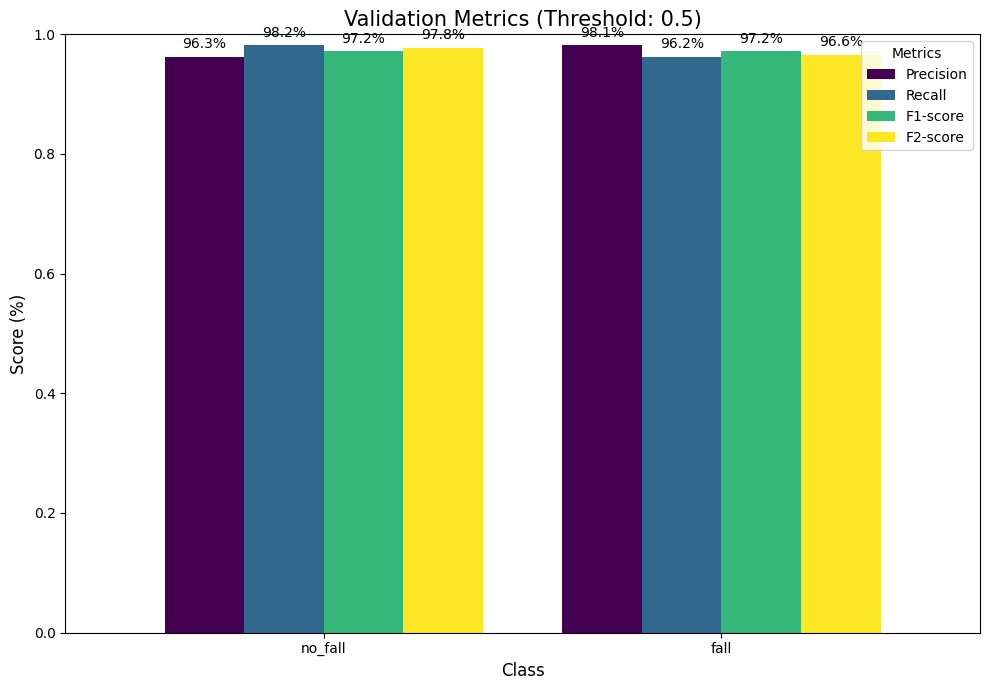

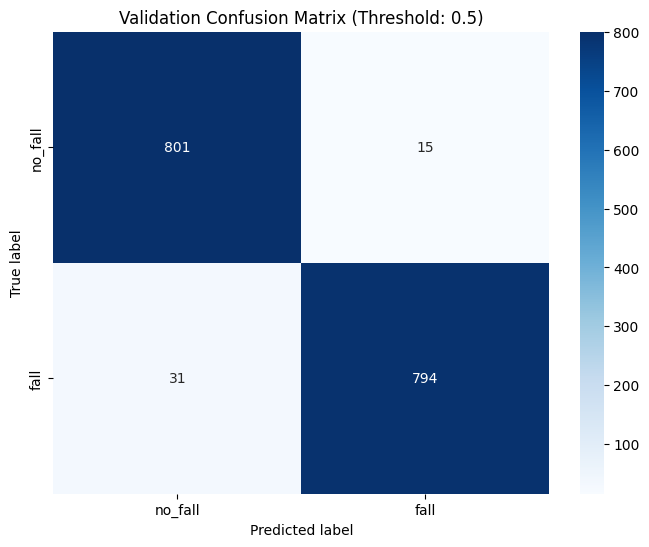



--- Custom Test Metrics Report (Threshold: 0.5) ---
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           Precision     Recall   F1-score   F2-score    Support
no_fall       0.9533     0.9779     0.9655     0.9729        815
fall          0.9776     0.9528     0.9651     0.9577        826


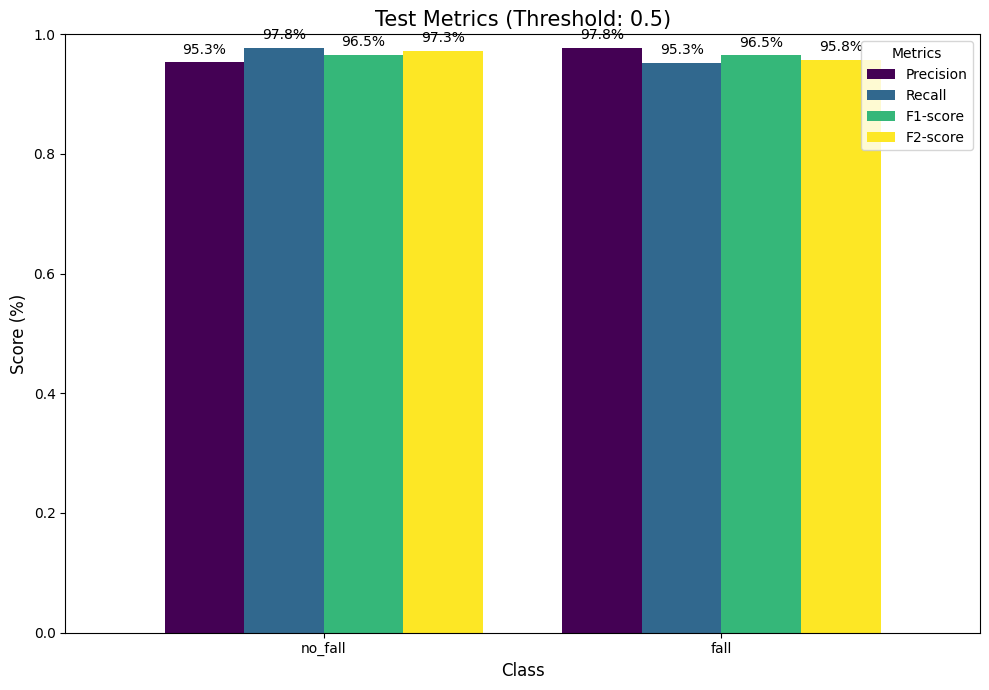

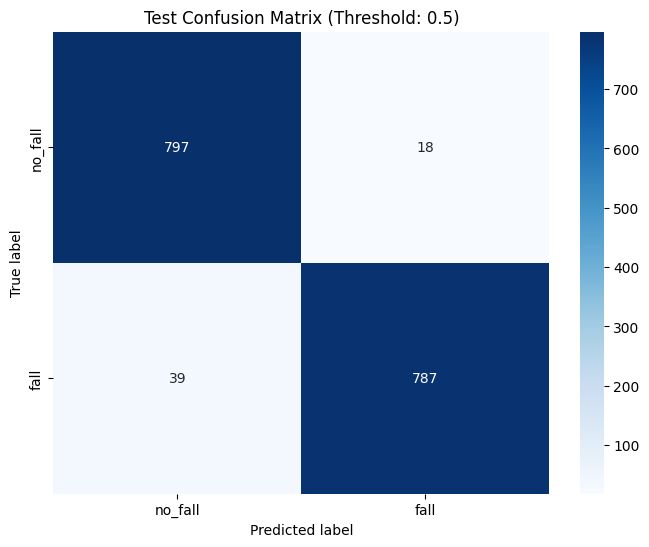

In [20]:
# ----- FUNCTION TO PLOT CONFUSION MATRIX -----
def plot_confusion_matrix_custom(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title); plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.show()

# ----- FUNCTION TO PLOT METRICS BARCHART  -----
def plot_metrics_barchart(metrics_data, class_names, title='Metrics per Class'):
    df_metrics = pd.DataFrame(metrics_data, index=class_names)
    ax = df_metrics.plot(kind='bar', figsize=(10, 7), width=0.8, colormap='viridis')
    plt.title(title, fontsize=15); plt.ylabel('Score (%)', fontsize=12); plt.xlabel('Class', fontsize=12)
    plt.xticks(rotation=0); plt.ylim(0, 1)
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)
    plt.legend(title='Metrics'); plt.tight_layout(); plt.show()

# ----- DETAILED EVALUATION AND REPORTING -----
target_names = ['no_fall', 'fall']
class_labels = [0, 1] # Corresponding numerical labels

# Initialize prediction variables to None
y_pred_val_probs = None
y_pred_val_classes = None
y_pred_test_probs = None
y_pred_test_classes = None

# --- กำหนด Optimized Threshold ที่คุณได้มา ---
OPTIMIZED_THRESHOLD = 0.5 # หรือค่าที่คุณได้จากการทดลองล่าสุด

if final_model is not None:
    # --- Evaluation on Validation Set ---
    if X_val_orig.size > 0 and y_val_orig.size > 0:
        print(f"\n\n--- Custom Validation Metrics Report (Threshold: {OPTIMIZED_THRESHOLD}) ---")
        y_pred_val_probs = final_model.predict(X_val_orig)
        # --- ใช้ OPTIMIZED_THRESHOLD ที่นี่ ---
        y_pred_val_classes = (y_pred_val_probs > OPTIMIZED_THRESHOLD).astype(int).flatten()
        
        precision_val, recall_val, f1_val, support_val = precision_recall_fscore_support(
            y_val_orig, y_pred_val_classes, labels=class_labels, zero_division=0
        )
        f2_val_per_class = fbeta_score(y_val_orig, y_pred_val_classes, beta=2, labels=class_labels, average=None, zero_division=0)
        # ... (ส่วนที่เหลือของการ print report และ plot ของ validation) ...
        print(f"{'':9} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'F2-score':>10} {'Support':>10}")
        for i, class_name in enumerate(target_names):
            print(f"{class_name:9} {precision_val[i]:>10.4f} {recall_val[i]:>10.4f} {f1_val[i]:>10.4f} {f2_val_per_class[i]:>10.4f} {support_val[i]:>10}")
        val_metrics_for_plot = {'Precision': precision_val, 'Recall': recall_val, 'F1-score': f1_val, 'F2-score': f2_val_per_class}
        plot_metrics_barchart(val_metrics_for_plot, target_names, title=f'Validation Metrics (Threshold: {OPTIMIZED_THRESHOLD})')
        cm_val = confusion_matrix(y_val_orig, y_pred_val_classes, labels=class_labels)
        plot_confusion_matrix_custom(cm_val, classes=target_names, title=f'Validation Confusion Matrix (Threshold: {OPTIMIZED_THRESHOLD})')

    else: print("\nValidation data empty. Skipping detailed validation metrics report.")

    # --- Evaluation on Test Set ---
    if X_test_orig.size > 0 and y_test_orig.size > 0:
        print(f"\n\n--- Custom Test Metrics Report (Threshold: {OPTIMIZED_THRESHOLD}) ---")
        y_pred_test_probs = final_model.predict(X_test_orig)
        # --- ใช้ OPTIMIZED_THRESHOLD ที่นี่ ---
        y_pred_test_classes = (y_pred_test_probs > OPTIMIZED_THRESHOLD).astype(int).flatten()
        
        precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(
            y_test_orig, y_pred_test_classes, labels=class_labels, zero_division=0
        )
        f2_test_per_class = fbeta_score(y_test_orig, y_pred_test_classes, beta=2, labels=class_labels, average=None, zero_division=0)
        # ... (ส่วนที่เหลือของการ print report และ plot ของ test) ...
        print(f"{'':9} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'F2-score':>10} {'Support':>10}")
        for i, class_name in enumerate(target_names):
            print(f"{class_name:9} {precision_test[i]:>10.4f} {recall_test[i]:>10.4f} {f1_test[i]:>10.4f} {f2_test_per_class[i]:>10.4f} {support_test[i]:>10}")
        test_metrics_for_plot = {'Precision': precision_test, 'Recall': recall_test, 'F1-score': f1_test, 'F2-score': f2_test_per_class}
        plot_metrics_barchart(test_metrics_for_plot, target_names, title=f'Test Metrics (Threshold: {OPTIMIZED_THRESHOLD})')
        cm_test = confusion_matrix(y_test_orig, y_pred_test_classes, labels=class_labels)
        plot_confusion_matrix_custom(cm_test, classes=target_names, title=f'Test Confusion Matrix (Threshold: {OPTIMIZED_THRESHOLD})')
    else: print("\nTest data empty. Skipping detailed test metrics.")
else:
    print("Final model not trained. Skipping detailed evaluation.")
    


In [21]:
from sklearn.metrics import f1_score

# y_pred_val_probs ได้จากการ predict บน X_val_orig
best_threshold = 0.5
best_f1 = 0.0
thresholds = np.arange(0.1, 0.9, 0.01)
for thresh in thresholds:
    current_preds = (y_pred_val_probs > thresh).astype(int)
    current_f1 = f1_score(y_val_orig, current_preds, average='macro') # หรือ average='binary' ถ้าสนใจ F1 ของคลาส fall
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = thresh
print(f"Best threshold on validation set: {best_threshold:.2f} with F1-Macro: {best_f1:.4f}")

Best threshold on validation set: 0.46 with F1-Macro: 0.9726


In [22]:
# ----- Error Analysis and Logging to CSV -----
import numpy as np
import pandas as pd
from pathlib import Path
import csv


print("\nStarting Error Analysis and Logging to CSV...")
csv_error_log_filename = "error_analysis_report.csv"

# --- DEFINITION OF TARGET NAMES (IMPORTANT!) ---
# ตรวจสอบให้แน่ใจว่าการ map นี้ถูกต้องตาม labels ที่โมเดลของคุณใช้ (0 และ 1)
target_names_map_global = {
    0: 'no_fall',  # Label 0 คือ 'no_fall'
    1: 'fall'      # Label 1 คือ 'fall'
}
# ---------------------------------------------

# --- Function to process and write errors for a given set (val or test) ---
def log_errors_to_csv_list(data_set_name, y_true, y_pred_classes, y_pred_probs, filepaths, target_names_dict, csv_rows_list):
    # ตรวจสอบว่า target_names_dict เป็น dictionary
    if not isinstance(target_names_dict, dict):
        print(f"ERROR in log_errors_to_csv_list: target_names_dict for {data_set_name} is not a dictionary. Skipping.")
        return False

    if not (y_true is not None and y_pred_classes is not None and y_pred_probs is not None and filepaths is not None and
            y_true.size > 0 and len(filepaths) > 0 and y_pred_classes.size > 0 and y_pred_probs.size > 0 and
            len(y_true) == len(filepaths) == len(y_pred_classes) == y_pred_probs.shape[0]):
        print(f"Warning: Data for {data_set_name} error analysis is incomplete or mismatched. Skipping {data_set_name} set.")
        return False

    fp_indices = np.where((y_pred_classes == 1) & (y_true == 0))[0]
    fn_indices = np.where((y_pred_classes == 0) & (y_true == 1))[0]

    print(f"\n--- Analyzing {data_set_name} Set ---")
    print(f"Total {data_set_name} Samples: {len(y_true)}")
    print(f"False Positives (No_Fall predicted as Fall): {len(fp_indices)}")
    print(f"False Negatives (Fall predicted as No_Fall): {len(fn_indices)}")

    # Process False Positives
    for fp_idx in fp_indices:
        true_label_int = int(y_true[fp_idx]) # Ensure integer for dict key
        pred_label_int = int(y_pred_classes[fp_idx])
        
        pred_prob_fall = y_pred_probs[fp_idx]
        if isinstance(pred_prob_fall, (np.ndarray, list)): # Handle if probs are in array/list per sample
            pred_prob_fall = pred_prob_fall[0] if len(pred_prob_fall) == 1 else (pred_prob_fall[1] if len(pred_prob_fall) > 1 and pred_label_int == 1 else pred_prob_fall[pred_label_int])


        npy_full_path_str = filepaths[fp_idx]
        npy_filename = Path(npy_full_path_str).name
        
        csv_rows_list.append({
            'File Name': npy_filename,
            'True': target_names_dict.get(true_label_int, str(true_label_int)),
            'Pred': target_names_dict.get(pred_label_int, str(pred_label_int)),
            'Prob': f"{pred_prob_fall:.4f}",
            'Type': 'FP',
            'Set': data_set_name
        })

    # Process False Negatives
    for fn_idx in fn_indices:
        true_label_int = int(y_true[fn_idx]) # Ensure integer
        pred_label_int = int(y_pred_classes[fn_idx])
        
        pred_prob_fall = y_pred_probs[fn_idx]
        if isinstance(pred_prob_fall, (np.ndarray, list)): # Handle if probs are in array/list per sample
            pred_prob_fall = pred_prob_fall[0] # Assuming sigmoid output P(Fall)

        npy_full_path_str = filepaths[fn_idx]
        npy_filename = Path(npy_full_path_str).name
        
        csv_rows_list.append({
            'File Name': npy_filename,
            'True': target_names_dict.get(true_label_int, str(true_label_int)),
            'Pred': target_names_dict.get(pred_label_int, str(pred_label_int)),
            'Prob': f"{pred_prob_fall:.4f}",
            'Type': 'FN',
            'Set': data_set_name
        })
    return True


# --- Main CSV Logging Logic ---
all_error_rows = []

# ใช้ target_names_map_global ที่กำหนดไว้ด้านบน
print(f"Using target names map: {target_names_map_global}")

# --- Validation Set Analysis ---
val_analyzed_success = False # เปลี่ยนชื่อตัวแปรเพื่อความชัดเจน
if 'y_val_orig' in locals() and 'y_pred_val_classes' in locals() and \
   'y_pred_val_probs' in locals() and 'val_npy_filepaths' in locals():
    print("Proceeding with Validation Set Error Analysis...")
    val_analyzed_success = log_errors_to_csv_list(
        data_set_name='val',
        y_true=np.array(y_val_orig).flatten(), # Ensure y_val_orig is 1D
        y_pred_classes=np.array(y_pred_val_classes).flatten(),
        y_pred_probs=np.array(y_pred_val_probs).flatten(), # Ensure y_pred_val_probs is 1D for P(Fall)
        filepaths=val_npy_filepaths,
        target_names_dict=target_names_map_global, # ส่ง dictionary เข้าไป
        csv_rows_list=all_error_rows
    )
else:
    print("Skipping Validation Set Error Analysis: One or more required variables are missing "
          "(y_val_orig, y_pred_val_classes, y_pred_val_probs, val_npy_filepaths).")

# --- Test Set Analysis ---
test_analyzed_success = False # เปลี่ยนชื่อตัวแปรเพื่อความชัดเจน
if 'y_test_orig' in locals() and 'y_pred_test_classes' in locals() and \
   'y_pred_test_probs' in locals() and 'test_npy_filepaths' in locals():
    print("Proceeding with Test Set Error Analysis...")
    test_analyzed_success = log_errors_to_csv_list(
        data_set_name='test',
        y_true=np.array(y_test_orig).flatten(), # Ensure y_test_orig is 1D
        y_pred_classes=np.array(y_pred_test_classes).flatten(),
        y_pred_probs=np.array(y_pred_test_probs).flatten(), # Ensure y_pred_test_probs is 1D for P(Fall)
        filepaths=test_npy_filepaths,
        target_names_dict=target_names_map_global, # ส่ง dictionary เข้าไป
        csv_rows_list=all_error_rows
    )
else:
    print("Skipping Test Set Error Analysis: One or more required variables are missing "
          "(y_test_orig, y_pred_test_classes, y_pred_test_probs, test_npy_filepaths).")

# --- Write to CSV File ---
if all_error_rows:
    fieldnames = ['#', 'File Name', 'True', 'Pred', 'Prob', 'Type', 'Set']
    
    with open(csv_error_log_filename, "w", newline='', encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i, row_dict in enumerate(all_error_rows):
            row_dict_with_index = {'#': i + 1, **row_dict}
            writer.writerow(row_dict_with_index)
    print(f"\nError Analysis Report (CSV) saved to: {csv_error_log_filename}")
elif not val_analyzed_success and not test_analyzed_success:
    fieldnames = ['#', 'File Name', 'True', 'Pred', 'Prob', 'Type', 'Set']
    with open(csv_error_log_filename, "w", newline='', encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerow({'#': '', 'File Name': 'No data available for analysis or required variables missing.',
                         'True': '', 'Pred': '', 'Prob': '', 'Type': '', 'Set': ''})
    print(f"Empty Error Analysis Report (CSV) created at: {csv_error_log_filename} (No data for analysis).")
else: # กรณีที่ val หรือ test ถูกวิเคราะห์ แต่ไม่มี error ให้ log
    if not all_error_rows and (val_analyzed_success or test_analyzed_success):
        fieldnames = ['#', 'File Name', 'True', 'Pred', 'Prob', 'Type', 'Set']
        with open(csv_error_log_filename, "w", newline='', encoding="utf-8") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerow({'#': '', 'File Name': 'No False Positives or False Negatives found in the analyzed set(s).',
                             'True': '', 'Pred': '', 'Prob': '', 'Type': '', 'Set': ''})
        print(f"\nError Analysis Report (CSV) indicates no FP/FN found: {csv_error_log_filename}")



Starting Error Analysis and Logging to CSV...
Using target names map: {0: 'no_fall', 1: 'fall'}
Proceeding with Validation Set Error Analysis...

--- Analyzing val Set ---
Total val Samples: 1641
False Positives (No_Fall predicted as Fall): 15
False Negatives (Fall predicted as No_Fall): 31
Proceeding with Test Set Error Analysis...

--- Analyzing test Set ---
Total test Samples: 1641
False Positives (No_Fall predicted as Fall): 18
False Negatives (Fall predicted as No_Fall): 39

Error Analysis Report (CSV) saved to: error_analysis_report.csv
